In [1]:
import dash, dash_core_components as dcc, dash_html_components as html, pandas as pd, torch, torch.nn as nn
from dash.dependencies import Input, Output
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from pathlib import Path

C:\Users\sebas\AppData\Local\Temp\ipykernel_20916\124284584.py:1: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash, dash_core_components as dcc, dash_html_components as html, pandas as pd, torch, torch.nn as nn
C:\Users\sebas\AppData\Local\Temp\ipykernel_20916\124284584.py:1: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash, dash_core_components as dcc, dash_html_components as html, pandas as pd, torch, torch.nn as nn


In [2]:
class ClaimDataset(Dataset):
    def __init__(self, data):
        self.X = data.drop("Claim", axis=1).values
        self.claim = data['Claim'].values
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.claim = torch.tensor(self.claim, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.claim[idx]
    
class ClaimPredictor(nn.Module):

    torch.manual_seed(42)
    
    def __init__(self, input_size, hidden_size, output_size):
        super(ClaimPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = (torch.sigmoid(out)-0.4999)
        out = torch.round(out)
        return out

In [3]:
# Load the data and perform scaling


base_path = Path()
travel_data = base_path.joinpath('travel_insurance.csv')
travel_df = pd.read_csv(travel_data)
travel_df.dropna(inplace=True)


pred_series = travel_df["Claim"].apply(lambda x: 1 if x == 'Yes' else 0)
travel_df.drop(columns=["Claim"], inplace=True)

numeric_cols = []
categorical_cols = []
for col in travel_df.columns:
    if travel_df[col].dtype == 'object':
        categorical_cols.append(col)
    else:
        numeric_cols.append(col)
ord_enc = OrdinalEncoder()
stand_enc = StandardScaler()
travel_df[categorical_cols] = ord_enc.fit_transform(travel_df[categorical_cols])
travel_df[numeric_cols] = stand_enc.fit_transform(travel_df[numeric_cols])
travel_df["Claim"] = pred_series
display(travel_df.head())

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
0,3.0,1.0,0.0,9.0,1.038213,43.0,-1.170622,-0.356954,0.0,1.733272,0
1,3.0,1.0,0.0,9.0,1.038213,43.0,-1.170622,-0.356954,0.0,1.254660,0
5,8.0,0.0,1.0,21.0,-0.023974,79.0,-2.415836,0.956221,0.0,-0.037592,0
11,8.0,0.0,1.0,6.0,-0.599326,43.0,-1.021737,-0.487951,1.0,0.105991,0
12,9.0,1.0,1.0,12.0,-0.139045,56.0,-2.537650,1.238646,0.0,0.153853,0


In [4]:
# Create a DataLoader for inference
inference_dataset = ClaimDataset(travel_df)
inference_loader = DataLoader(inference_dataset, batch_size=32, shuffle=False)

# Define the model parameters
input_size = inference_dataset.X.shape[1]
hidden_size = 64
output_size = 1

# Load the trained model
model = ClaimPredictor(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('insurance_model.pt'))
model.eval()

# Un-encode categorical data
travel_df[categorical_cols] = ord_enc.inverse_transform(travel_df[categorical_cols])
travel_df[numeric_cols] = stand_enc.inverse_transform(travel_df[numeric_cols])

In [5]:
# Initialize the Dash app

app = dash.Dash(__name__)

# Define the app layout
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Travel Insurance Prediction"),
    html.Div([
        html.Div([
            html.Label("Agency"),
            dcc.Dropdown(
                id='agency-dropdown',
                options=[{'label': agency, 'value': agency} for agency in travel_df['Agency'].unique()],
                value=travel_df['Agency'][0]
            )
        ], className='dropdown'),
        
        html.Div([
            html.Label("Agency Type"),
            dcc.Dropdown(
                id='agency-type-dropdown',
                options=[{'label': agency_type, 'value': agency_type} for agency_type in travel_df['Agency Type'].unique()],
                value=travel_df['Agency Type'][0]
            )
        ], className='dropdown'),
        
        html.Div([
            html.Label("Distribution Channel"),
            dcc.Dropdown(
                id='distribution-channel-dropdown',
                options=[{'label': channel, 'value': channel} for channel in travel_df['Distribution Channel'].unique()],
                value=travel_df['Distribution Channel'][0]
            )
        ], className='dropdown'),
        
        html.Div([
            html.Label("Product Name"),
            dcc.Dropdown(
                id='product-name-dropdown',
                options=[{'label': product, 'value': product} for product in travel_df['Product Name'].unique()],
                value=travel_df['Product Name'][0]
            )
        ], className='dropdown'),
        
        html.Div([
            html.Label("Duration"),
            dcc.Input(
                id='duration-input',
                type='number',
                value=travel_df['Duration'].min()
            )
        ], className='input'),
        
        html.Div([
            html.Label("Destination"),
            dcc.Dropdown(
                id='destination-dropdown',
                options=[{'label': destination, 'value': destination} for destination in travel_df['Destination'].unique()],
                value=travel_df['Destination'][0]
            )
        ], className='dropdown'),
        
        html.Div([
            html.Label("Gender"),
            dcc.Dropdown(
                id='gender-dropdown',
                options=[{'label': gender, 'value': gender} for gender in travel_df['Gender'].unique()],
                value=travel_df['Gender'][0]
            )
        ], className='dropdown'),
        
        html.Div([
            html.Label("Age"),
            dcc.Input(
                id='age-input',
                type='number',
                value=travel_df['Age'].min()
            )
        ], className='input'),

        html.Div([
            html.Label("Net Sales"),
            dcc.Input(
                id='sales-input',
                type='number',
                value=travel_df['Net Sales'].min()
            )
        ], className='input'),

        html.Div([
            html.Label("Commision"),
            dcc.Input(
                id='commision-input',
                type='number',
                value=travel_df['Commision (in value)'].min()
            )
        ], className='input'),
        
        html.Div([
            html.Button('Predict', id='predict-button')
        ], className='button')
    ], className='panel'),
    
    html.Div([], id='prediction-output'),

    html.Div([ 
        html.Table([
        html.Tr([
            [html.Th(col) for col in travel_df.columns.values], 
            html.Th("Prediction")
            ]), []
        ], id='log-container')
    ], id = 'log-div', style={'overflowY': 'scroll', 'height': '200px', 'border-collapse': 'collapse'})
])

def update_log(log_container_children, agency, agency_type, distribution_channel, product_name, duration, destination, gender, age, net_sales, commision, prediction):
    log_entry = html.Tr([
        html.Td(agency),
        html.Td(agency_type),
        html.Td(distribution_channel),
        html.Td(product_name),
        html.Td(duration),
        html.Td(destination),
        html.Td(gender),
        html.Td(age),
        html.Td(net_sales),
        html.Td(commision),
        html.Td(prediction)
        ])
    
    return log_container_children + [log_entry]

# Callback function to generate prediction based on selected values
@app.callback(
    [
        dash.dependencies.Output('log-container', 'children'),
        dash.dependencies.Output('prediction-output', 'children')
    ],
    [dash.dependencies.Input('predict-button', 'n_clicks')],
    [
        dash.dependencies.State('agency-dropdown', 'value'),
        dash.dependencies.State('agency-type-dropdown', 'value'),
        dash.dependencies.State('distribution-channel-dropdown', 'value'),
        dash.dependencies.State('product-name-dropdown', 'value'),
        dash.dependencies.State('duration-input', 'value'),
        dash.dependencies.State('destination-dropdown', 'value'),
        dash.dependencies.State('gender-dropdown', 'value'),
        dash.dependencies.State('age-input', 'value'),
        dash.dependencies.State('sales-input', 'value'),
        dash.dependencies.State('commision-input', 'value'),
        dash.dependencies.State('log-container', 'children')
    ]
)
def generate_prediction(n_clicks, agency, agency_type, distribution_channel, product_name, duration, destination, gender, age, net_sales, commision, log_container):
    # Create a sample input based on the selected values
    input_data = pd.DataFrame({
        'Agency': [agency],
        'Agency Type': [agency_type],
        'Distribution Channel': [distribution_channel],
        'Product Name': [product_name],
        'Duration': [duration],
        'Destination': [destination],
        'Gender': [gender],
        'Age': [age],
        'Net Sales': [net_sales],
        'Commision (in value)': [commision]
    })
    
    # Perform ordinal encoding on the input data
    input_data[categorical_cols] = ord_enc.fit_transform(input_data[categorical_cols])
    
    # Scale the input data
    scaled_data = stand_enc.fit_transform(input_data)
    
    # Convert the input data to tensor
    input_tensor = torch.tensor(scaled_data, dtype=torch.float32)
    
    # Make the prediction using the pre-trained model
    with torch.no_grad():
        prediction = model(input_tensor).squeeze().item()
        
    # Format the prediction result
    result = 'Yes' if prediction == 1 else 'No'
    
    # Return the prediction result

    log = update_log(log_container, agency, agency_type, distribution_channel, product_name, duration, destination, gender, age, net_sales, commision, result)
    return log, html.Div([
        html.H3('Prediction:'),
        html.H4(result)
    ])



In [6]:
app.run()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [28/May/2023 17:21:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:21:25] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:21:26] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:21:26] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [28/May/2023 17:21:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:21:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:21:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:22:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:22:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:22:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:22:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 17:22:39] "POST 

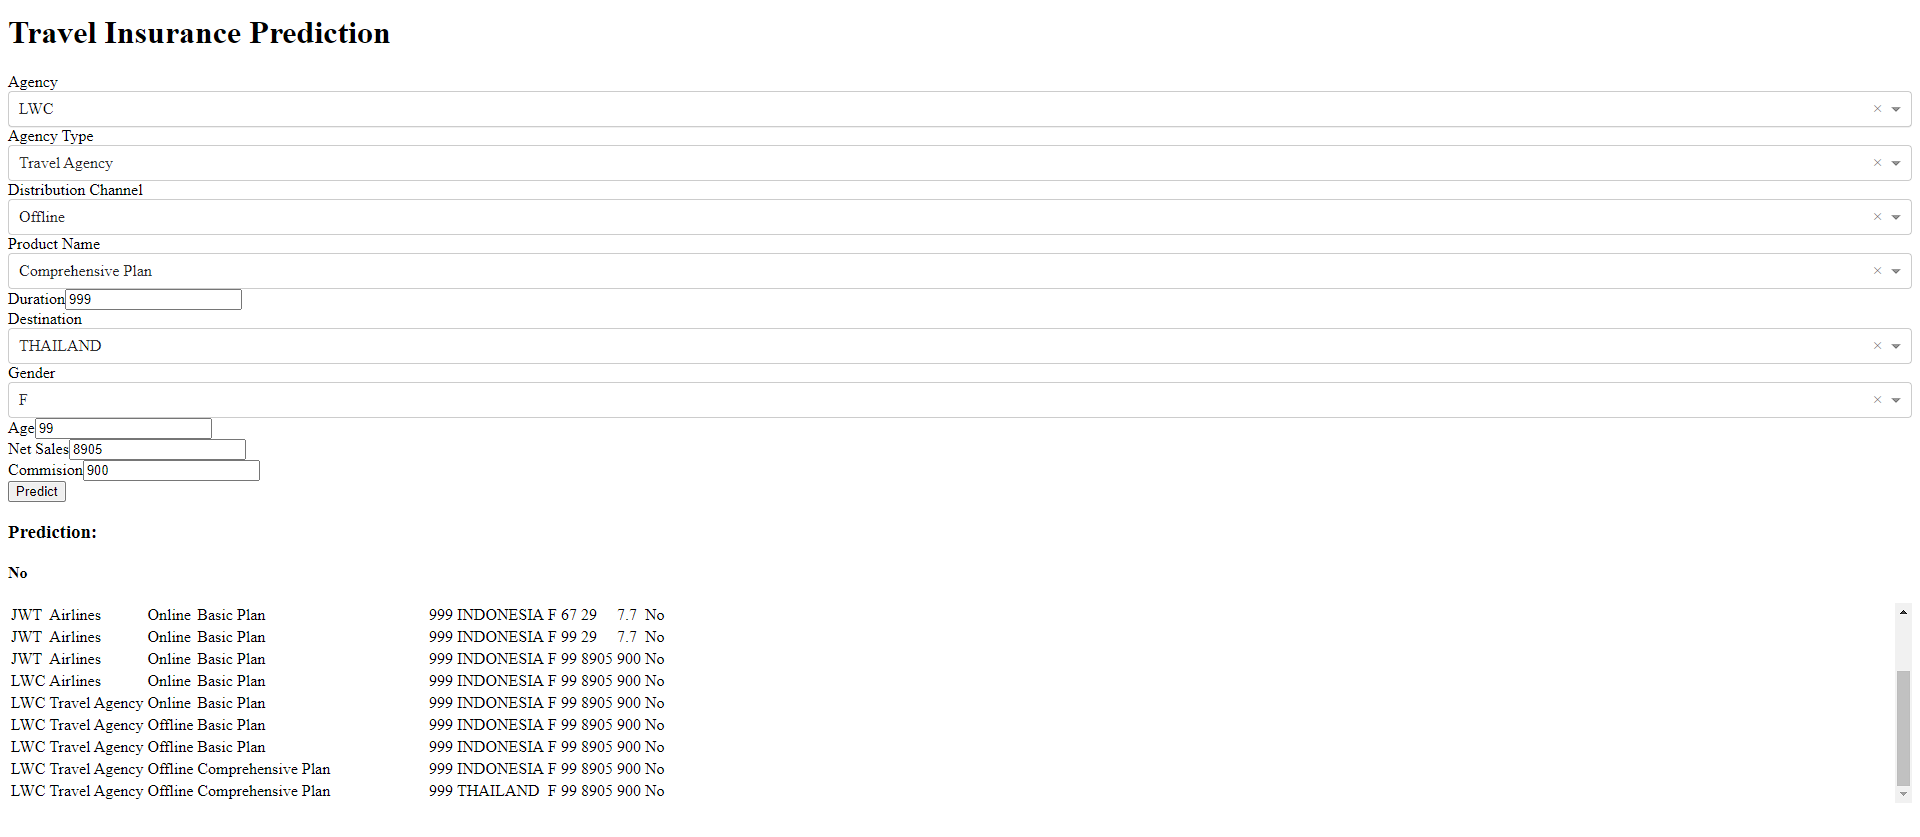

As seen above the the dash is relatively simple. A series of dropdowns and numerical inputs, with a simple predict button. With my original model for this, its hard to find a set of values that result in a True prediction, but the log indicates its processing the requests and predicting them. I know the model functions due to the previous assignment.

Unfortunately the table doesn't entirely work as I wished (CSS wasn't wanting to properly work for it border wise), and headers kept disappearing. All in all it is functional and works well enough for the purposes of the assignment, but it would be far from complete for a production application.